## Single step test



In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import sys

import torch
import math
import numpy as np
import wandb
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import TQDMProgressBar

import pyqg_explorer.dataset.forcing_dataset as forcing_dataset
import pyqg_explorer.models.base_model as base_model
import pyqg_explorer.util.pbar as pbar

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


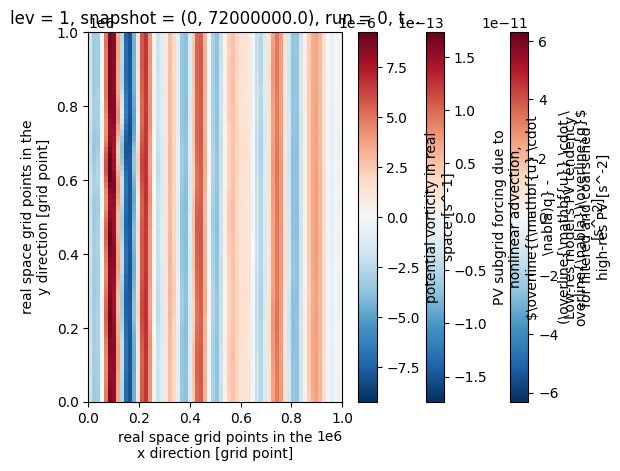

In [3]:
lev=0
data_full=xr.open_zarr(fsspec.get_mapper(f'/scratch/zanna/data/pyqg/publication/eddy/forcing1.zarr'), consolidated=True)
data_dqbar=data_full.dqbar_dt.isel(lev=0)
data_dqbar=data_dqbar.stack(snapshot=("run","time"))
data_dqbar=data_dqbar.transpose("snapshot","y","x")
data_dqbar.isel(snapshot=200).plot()
data_forcing=data_full.q_subgrid_forcing.isel(lev=lev)
data_forcing=data_forcing.stack(snapshot=("run","time"))
data_forcing=data_forcing.transpose("snapshot","y","x")
data_forcing.isel(snapshot=20).plot()
data_q=data_full.q.isel(lev=0)
data_q=data_q.stack(snapshot=("run","time"))
data_q=data_q.transpose("snapshot","y","x")
data_q.isel(snapshot=20).plot()

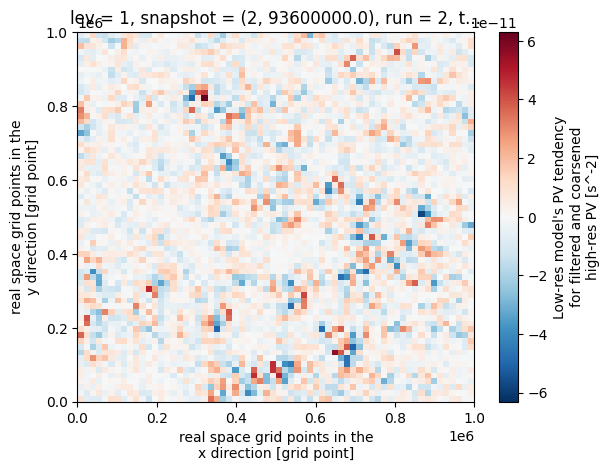

In [4]:
data_dqbar=data_full.dqbar_dt.isel(lev=0)
data_dqbar=data_dqbar.stack(snapshot=("run","time"))
data_dqbar=data_dqbar.transpose("snapshot","y","x")
data_dqbar.isel(snapshot=200).plot()

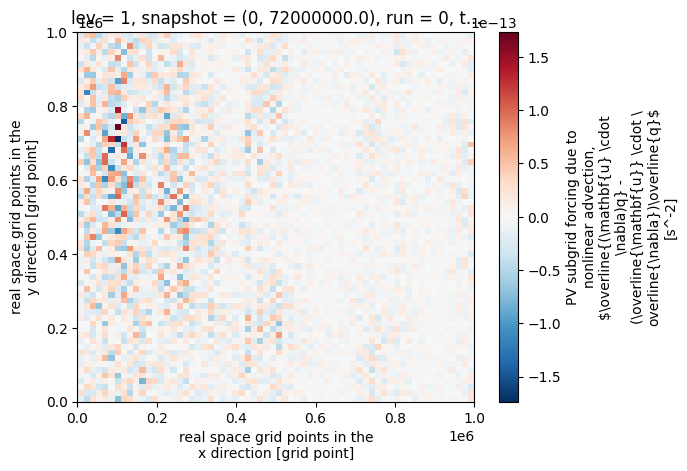

In [5]:
data_forcing=data_full.q_subgrid_forcing.isel(lev=lev)
data_forcing=data_forcing.stack(snapshot=("run","time"))
data_forcing=data_forcing.transpose("snapshot","y","x")
data_forcing.isel(snapshot=20).plot()

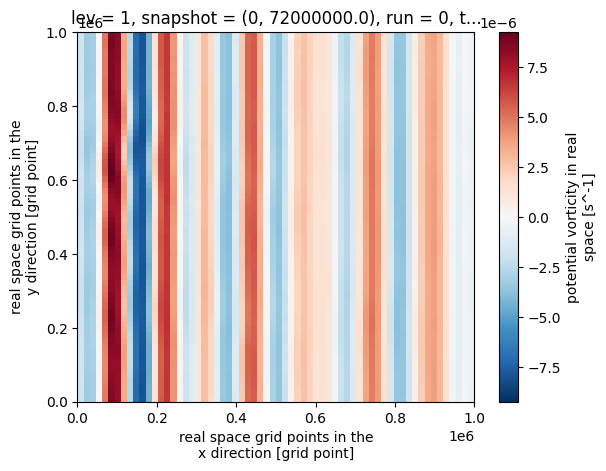

In [6]:
data_q=data_full.q.isel(lev=0)
data_q=data_q.stack(snapshot=("run","time"))
data_q=data_q.transpose("snapshot","y","x")
data_q.isel(snapshot=20).plot()

del data_full

In [7]:
## Build a single-step dataset
class SingleStepDataset(Dataset):
    """
    Subgrid forcing maps dataset
    """
    def __init__(self,pv,dqbar_dt,s,seed=42,train_ratio=0.75,valid_ratio=0.25,test_ratio=0.0):
        """
        pv:          xarray of the PV field
        dqbar_dt:    xarray of PV tendency
        s:           xarray of the subgrid forcing field
        seed:        random seed used to create train/valid/test splits
        train_ratio: proportion of dataset to use as training data
        valid_ratio: proportion of dataset to use as validation data
        test_ratio:  proportion of dataset to use as test data
        
        """
        super().__init__()
        self.pv=torch.unsqueeze(torch.tensor(pv.to_numpy()),dim=1)
        self.dqbar_dt=torch.unsqueeze(torch.tensor(dqbar_dt.to_numpy()),dim=1)
        self.s=torch.unsqueeze(torch.tensor(s.to_numpy()),dim=1)
        ## Generate array for Q_i+1
        self.pv_plusone=torch.roll(self.pv,1,dims=0)
        
        ## Drop last index, where we have no i+1
        self.pv=self.pv[:-1, :, :, :]
        self.dqbar_dt=self.dqbar_dt[:-1, :, :, :]
        self.s=self.s[:-1, :, :, :]
        self.pv_plusone=self.pv_plusone[1:, :, :, :]
        
        ## Cat into x_data
        self.x_data=torch.cat((self.pv,self.dqbar_dt,self.s),1)
        self.y_data=self.pv_plusone
        
        self.train_ratio=train_ratio
        self.valid_ratio=valid_ratio
        self.test_ratio=test_ratio
        self.rng = np.random.default_rng(seed)

        self.x_renorm=torch.std(self.x_data)
        self.y_renorm=torch.std(self.y_data)
        self.x_data=self.x_data/self.x_renorm
        self.y_data=self.y_data/self.y_renorm
        self.len=len(self.x_data)
        
        assert len(self.x_data)==len(self.y_data), "Number of x and y samples should be the same"
        
        self._get_split_indices()
        
    def _get_split_indices(self):
        """ Set indices for train, valid and test splits """

        ## Randomly shuffle indices of entire dataset
        rand_indices=self.rng.permutation(np.arange(self.len))

        ## Set number of train, valid and test points
        num_train=math.floor(self.len*self.train_ratio)
        num_valid=math.floor(self.len*self.valid_ratio)
        num_test=math.floor(self.len*self.test_ratio)
        
        ## Make sure we aren't overcounting
        assert (num_train+num_valid+num_test) <= self.len
        
        ## Pick train, test and valid indices from shuffled list
        self.train_idx=rand_indices[0:num_train]
        self.valid_idx=rand_indices[num_train+1:num_train+num_valid]
        self.test_idx=rand_indices[len(self.valid_idx)+1:]
        
        ## Make sure there's no overlap between train, valid and test data
        assert len(set(self.train_idx) & set(self.valid_idx) & set(self.test_idx))==0, (
                "Common elements in train, valid or test set")
        
        
    def __len__(self):
        return self.len
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.x_data[idx],self.y_data[idx])

In [8]:
## From Andrew/Pavel's code, function to create a CNN block
def make_block(in_channels: int, out_channels: int, kernel_size: int, 
        ReLU = 'ReLU', batch_norm = True) -> list:
    '''
    Packs convolutional layer and optionally ReLU/BatchNorm2d
    layers in a list
    '''
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
        padding='same', padding_mode='circular')
    block = [conv]
    if ReLU == 'ReLU':
        block.append(nn.ReLU())
    elif ReLU == 'LeakyReLU':
        block.append(nn.LeakyReLU(0.2))
    elif ReLU == 'False':
        pass
    else:
        print('Error: wrong ReLU parameter')
    if batch_norm:
        block.append(nn.BatchNorm2d(out_channels))
    return block


class AndrewCNN(nn.Module):
    def __init__(self, n_in: int, n_out: int, x_renorm=torch.tensor(1.), y_renorm=torch.tensor(1.), ReLU = 'ReLU', lr=0.001) -> list:
        '''
        Packs sequence of 8 convolutional layers in a list.
        First layer has n_in input channels, and Last layer has n_out
        output channels
        '''
        super().__init__()
        self.lr=lr
        ## Register normalisation factors as buffers
        self.register_buffer('x_renorm', x_renorm)
        self.register_buffer('y_renorm', y_renorm)
        blocks = []
        blocks.extend(make_block(n_in,128,5,ReLU))                #1
        blocks.extend(make_block(128,64,5,ReLU))                  #2
        blocks.extend(make_block(64,32,3,ReLU))                   #3
        blocks.extend(make_block(32,32,3,ReLU))                   #4
        blocks.extend(make_block(32,32,3,ReLU))                   #5
        blocks.extend(make_block(32,32,3,ReLU))                   #6
        blocks.extend(make_block(32,32,3,ReLU))                   #7
        blocks.extend(make_block(32,n_out,3,'False',False))       #8
        self.conv = nn.Sequential(*blocks)

    def forward(self, x):
        x = self.conv(x)
        return x

In [9]:
single_dataset=SingleStepDataset(data_q,data_dqbar,data_forcing)

In [10]:
## Wandb config file
config={"lev":lev,
        "forcing":1,
        "framework":"Single-step loss"}

wandb.init(project="pyqg_single_step", entity="chris-pedersen",config=config)
train_loader = DataLoader(
    single_dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(single_dataset.train_idx),
)
valid_loader = DataLoader(
    single_dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(single_dataset.valid_idx),
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chris-pedersen. Use `wandb login --relogin` to force relogin


In [11]:
model_theta=base_model.AndrewCNN(1,1,single_dataset.x_renorm,single_dataset.y_renorm)
model_beta=base_model.AndrewCNN(2,1,single_dataset.x_renorm,single_dataset.y_renorm)

model_theta.to(device)
model_beta.to(device)

wandb.watch([model_theta,model_beta], log_freq=1)

[]

In [12]:
# optimizer parameters
beta1 = 0.5
beta2 = 0.999
lr = 0.01
wd = 0.05

optimizer = torch.optim.AdamW(list(model_theta.parameters()) + list(model_beta.parameters()), lr=lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

criterion=nn.MSELoss()

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times

    train_samples = 0.0
    train_running_loss = 0.0
    train_beta_running_loss = 0.0
    train_theta_running_loss = 0.0

    valid_running_loss = 0.0
    valid_beta_running_loss = 0.0
    valid_theta_running_loss = 0.0
    valid_samples = 0.0
    
    model_theta.train()
    model_beta.train()
    
    for i, data in enumerate(train_loader, 0):
        ## x_data is ordered in [pv, dqdt, s]
        x_data, y_data = data
        x_data=x_data.to(device)
        y_data=y_data.to(device)
    
        ## zero the parameter gradients
        optimizer.zero_grad()

        ## First network
        output_theta = model_theta(x_data[:,0,:,:].unsqueeze(1)) ## Takes in PV, outputs S
        ## Now evaluate F+\hat{S}, the tendency + estimated forcing
        F_plus_s_hat = output_theta+x_data[:,1,:,:].unsqueeze(1)
        ## Second network
        output_beta = model_beta(torch.cat((x_data[:,0,:,:].unsqueeze(1),F_plus_s_hat),1))
        
        loss_1 = criterion(output_theta, x_data[:,2,:,:].unsqueeze(1))
        loss_2 = criterion(output_beta, y_data)
        loss = loss_1+loss_2
        loss.backward()
        optimizer.step()
        
        
        ## Track loss for wandb
        train_running_loss+=loss.detach()
        train_theta_running_loss+=loss_1.detach()
        train_beta_running_loss+=loss_2.detach()
        train_samples+=x_data.shape[0]
        
        #print(train_running_loss)
    
    model_theta.eval()
    model_beta.eval()
    for i, data in enumerate(valid_loader, 0):
        ## x_data is ordered in [pv, dqdt, s]
        x_data, y_data = data
        x_data=x_data.to(device)
        y_data=y_data.to(device)
    
        ## zero the parameter gradients
        optimizer.zero_grad()

        ## First network
        output_theta = model_theta(x_data[:,0,:,:].unsqueeze(1)) ## Takes in PV, outputs S
        ## Now evaluate F+\hat{S}, the tendency + estimated forcing
        F_plus_s_hat = output_theta+x_data[:,1,:,:].unsqueeze(1)
        ## Second network
        output_beta = model_beta(torch.cat((x_data[:,0,:,:].unsqueeze(1),F_plus_s_hat),1))
        val_loss_1 = criterion(output_theta, x_data[:,2,:,:].unsqueeze(1))
        val_loss_2 = criterion(output_beta, y_data)
        val_loss = val_loss_1+val_loss_2
        ## Track loss for wandb
        valid_running_loss+=val_loss.detach()
        valid_samples+=x_data.shape[0]
        valid_theta_running_loss+=val_loss_1.detach()
        valid_beta_running_loss+=val_loss_2.detach()
    
    ## Push loss values for each epoch to wandb
    log_dic={}
    log_dic["training_loss"]=train_running_loss/train_samples
    log_dic["training_theta_loss"]=train_theta_running_loss/train_samples
    log_dic["training_beta_loss"]=train_beta_running_loss/train_samples
    log_dic["valid_loss"]=valid_running_loss/valid_samples
    log_dic["valid_theta_loss"]=valid_theta_running_loss/valid_samples
    log_dic["valid_beta_loss"]=valid_beta_running_loss/valid_samples
    wandb.log(log_dic)
    
    # verbose
    print('%03d %.3e %.3e '%(epoch, train_running_loss/train_samples, valid_running_loss), end='')
    print("")
    

000 1.634e-03 7.504e+00 
001 2.031e-04 1.025e+00 
002 1.529e-04 3.805e+00 
003 1.246e-04 1.280e+00 
004 1.216e-04 4.426e-01 
005 9.497e-05 1.961e+00 
006 1.263e-04 4.115e-01 
007 9.408e-05 1.244e-01 
008 9.495e-05 1.360e+00 
009 9.710e-05 4.138e+00 
010 1.002e-04 3.843e-01 
011 7.984e-05 8.581e-01 
012 9.828e-05 8.457e-01 
013 6.335e-04 4.219e-01 
014 5.533e-05 3.869e-01 
015 7.938e-05 9.556e+00 
016 9.495e-05 6.513e-01 
017 6.397e-05 2.451e+00 
018 1.100e-04 3.663e-01 
019 7.726e-05 3.365e-01 
020 6.833e-05 7.538e-01 
021 6.896e-05 2.651e-01 
022 8.504e-05 6.517e-01 
023 6.769e-05 1.082e+00 
024 6.203e-05 9.058e-01 
025 7.839e-05 1.381e+00 
026 6.621e-05 1.090e+01 
027 2.062e-03 2.976e-01 
028 5.139e-05 4.699e-01 
029 6.247e-05 3.374e-01 
030 5.181e-05 1.127e+00 
031 5.451e-05 1.357e+00 
032 5.703e-05 1.695e-01 
033 3.858e-03 1.170e+01 
034 9.196e-05 1.631e+00 
035 9.380e-05 1.175e+00 
036 3.980e-05 4.792e-01 
037 5.345e-05 4.506e-01 
038 6.809e-05 1.590e-01 
039 5.178e-05 4.794e-01 


In [19]:
model_theta.state_dict()

OrderedDict([('x_renorm', tensor(4.5456e-06, device='cuda:0')),
             ('y_renorm', tensor(7.8603e-06, device='cuda:0')),
             ('conv.0.weight',
              tensor([[[[ 5.8027e-08, -1.0683e-07, -7.3940e-09,  4.6792e-08,  1.1348e-07],
                        [-1.8990e-07,  8.2886e-08, -8.0464e-08, -6.7615e-08,  1.3500e-08],
                        [-1.9552e-08, -2.1762e-08,  8.9844e-08,  1.5200e-08, -1.5601e-07],
                        [ 8.2231e-09, -9.9111e-08,  1.6987e-07,  8.8019e-08,  5.4823e-08],
                        [ 3.7509e-08, -1.3441e-07, -1.2154e-07,  2.6009e-08,  1.1206e-07]]],
              
              
                      [[[-3.9343e-08, -8.4510e-08, -8.2446e-08, -5.1516e-08,  7.4116e-08],
                        [-9.4041e-08,  5.9084e-08,  8.1378e-08, -6.5455e-08,  5.1290e-08],
                        [ 3.5740e-08,  1.4409e-07, -1.4088e-07, -1.4053e-07,  1.3317e-07],
                        [ 1.7617e-08, -3.4392e-08,  1.0326e-07,  7.6538e-08,  1.0

In [15]:
torch.save(model_theta.state_dict(), '/scratch/cp3759/pyqg_data/models/cnn_theta_upper.torch')
torch.save(model_beta.state_dict(), '/scratch/cp3759/pyqg_data/models/cnn_beta_upper.torch')

test


In [ ]:
x_train,y_train=next(iter(train_loader))

In [ ]:
x_train.shape

In [ ]:
x_train[:,1,:,:].unsqueeze(1).shape

In [ ]:
output_theta = model_theta(x_train[:,1,:,:].unsqueeze(1))

In [ ]:
output_theta.shape

In [ ]:
F_plus_shat=output_theta+x_train[:,1,:,:].unsqueeze(1)

In [ ]:
F_plus_shat.shape

In [ ]:
torch.cat((x_train[:,1,:,:].unsqueeze(1),F_plus_shat),1).shape

In [ ]:
output_beta = model_beta(torch.cat((x_train[:,1,:,:].unsqueeze(1),F_plus_shat),1)).shape

In [ ]:
c

In [ ]:
loss=(model_beta()-y_data)

In [ ]:
pv=torch.unsqueeze(torch.tensor(data_q.to_numpy()),dim=1)
dqbar_dt=torch.unsqueeze(torch.tensor(data_dqbar.to_numpy()),dim=1)
s=torch.unsqueeze(torch.tensor(data_forcing.to_numpy()),dim=1)

In [ ]:
pv_plusone=torch.roll(pv,1,dims=0)

In [ ]:
pv=pv[:-1, :, :, :]
pv_plusone=pv_plusone[1:, :, :, :]

In [ ]:
s=s[:-1, :, :, :]
dqbar_dt=dqbar_dt[:-1, :, :, :]

In [ ]:
torch.cat((pv,dqbar_dt,s),1).shape